In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [3]:
# VRP Environment with dynamic delivery points
class VRPEnvDirect:
    def __init__(self, num_delivery_points, area_size):
        self.num_delivery_points = num_delivery_points  # Number of delivery points
        self.area_size = area_size  # Size of the 2D area
        self.delivery_points = self.generate_delivery_points()
        self.state = self.reset()

    def generate_delivery_points(self):
        # Generate random delivery points within the specified area
        return [np.random.uniform(-self.area_size, self.area_size, 2) for _ in range(self.num_delivery_points)]

    def reset(self):
        # Reset vehicle to the starting point (e.g., [0, 0]) and set all delivery points to unvisited
        self.vehicle_position = np.array([0.0, 0.0])
        self.visited = np.zeros(len(self.delivery_points), dtype=bool)
        self.total_distance = 0
        self.path = [self.vehicle_position.copy()]
        return self.get_state()

    def get_state(self):
        # State includes vehicle position and visited delivery points
        return {
            'vehicle_position': self.vehicle_position.copy(),
            'visited': self.visited.copy()
        }

    def step(self, action):
      # Directly move to the chosen delivery point
      target_position = self.delivery_points[action]

      # Calculate the Euclidean distance for the move
      distance = self.euclidean_distance(self.vehicle_position, target_position)

      # Penalize the agent for the distance traveled
      reward = -distance  # Negative reward based on distance traveled

      # Update total distance
      self.total_distance += distance
      self.vehicle_position = target_position
      self.path.append(self.vehicle_position.copy())

      # If the delivery point has not been visited, reward the agent
      if not self.visited[action]:
          reward += 10  # Large reward for visiting a new delivery point
          self.visited[action] = True

      done = self.is_done()
      next_state = self.get_state()
      return next_state, reward, done, {}

    def euclidean_distance(self, pos1, pos2):
        return np.linalg.norm(pos1 - pos2)

    def is_done(self):
        return np.all(self.visited)  # Done when all delivery points are visited

In [4]:
# DQN network for VRP with direct movement
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3):
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)  # Experience replay buffer
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.epsilon_min = 0.1  # Minimum value for epsilon
        self.model = DQN(state_dim, action_dim)  # Main model
        self.target_model = DQN(state_dim, action_dim)  # Target model for stability
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def choose_action(self, state):
        flat_state = self.flatten_state(state)

        # Create a list of valid actions (unvisited delivery points)
        valid_actions = [i for i in range(self.action_dim) if not state['visited'][i]]

        # If no valid actions, stop
        if not valid_actions:
            return None  # No more valid actions available

        if np.random.rand() <= self.epsilon:
            # Choose a random action from valid actions
            return random.choice(valid_actions)
        else:
            flat_state = torch.FloatTensor(flat_state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(flat_state)

            # Choose the best action among valid actions
            valid_action_values = [(i, action_values[0, i].item()) for i in valid_actions]
            best_action = max(valid_action_values, key=lambda x: x[1])[0]
            return best_action

    def store_experience(self, state, action, reward, next_state, done):
        # Flatten the state and next_state for storage
        flat_state = self.flatten_state(state)
        flat_next_state = self.flatten_state(next_state)

        # Store the experience in the memory buffer
        self.memory.append((flat_state, action, reward, flat_next_state, done))

    def flatten_state(self, state):
        # Flatten vehicle position and visited points
        return np.concatenate([state['vehicle_position'], state['visited'].astype(float)])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return  # Don't replay if we don't have enough experiences

        # Randomly sample a batch from the memory
        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item()

            target_f = self.model(state)
            target_f = target_f.clone().detach()  # Detach from computation graph
            target_f[action] = target

            # Train the network
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [6]:
# Updated training loop with path visualization at each iteration
def train_vrp(env, agent, num_episodes, batch_size=32):
    best_reward = float('-inf')  # Initialize best reward as negative infinity
    best_path = []  # To store the path for the best solution
    best_distance = float('inf')  # Initialize best distance as infinity

    rewards_per_episode = []  # To store the total reward per episode
    distance_per_episode = []  # To store the total distance per episode

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        step_count = 0

        while not done:
            action = agent.choose_action(state)

            if action is None:
                # All delivery points are visited, so end the episode
                break

            next_state, reward, done, _ = env.step(action)
            agent.store_experience(state, action, reward, next_state, done)
            total_reward += reward
            agent.replay(batch_size)
            state = next_state
            step_count += 1

        agent.update_target_network()
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

        # Track rewards and distances for plotting
        rewards_per_episode.append(total_reward)
        distance_per_episode.append(env.total_distance)

        # Check if the current episode is the best solution (highest reward or lowest distance)
        if total_reward > best_reward or (total_reward == best_reward and env.total_distance < best_distance):
            best_reward = total_reward
            best_distance = env.total_distance
            best_path = env.path.copy()  # Store the best path

        print(f'Episode {episode + 1}, Total Reward: {total_reward}, Total Distance: {env.total_distance}, Steps: {step_count}')

        # Visualize the path after each episode
        if episode % 400 == 0:
          visualize_path(env, env.delivery_points)

    # Plot reward and total distance for all episodes
    plot_metrics(rewards_per_episode, distance_per_episode)

    # Visualize the best solution path at the end of training
    visualize_best_path(best_path, env.delivery_points, best_reward, best_distance)


# Function to plot rewards and distance metrics
def plot_metrics(rewards, distances):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot rewards
    ax1.plot(rewards, label='Total Reward')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Total Reward vs Episode')
    ax1.grid(True)

    # Plot total distance
    ax2.plot(distances, label='Total Distance', color='orange')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Total Distance')
    ax2.set_title('Total Distance vs Episode')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Visualization function for the path after each episode
def visualize_path(env, delivery_points):
    path = np.array(env.path)
    plt.figure(figsize=(6, 6))
    plt.xlim(-env.area_size, env.area_size)
    plt.ylim(-env.area_size, env.area_size)
    plt.grid(True)

    # Plot delivery points
    for point in delivery_points:
        plt.scatter(point[0], point[1], c='red', marker='x', s=100, label='Delivery Point')

    # Plot agent's path with properly aligned arrows
    if len(path) > 1:
        # Calculate the differences (dx, dy) between consecutive points for plotting arrows
        dx = path[1:, 0] - path[:-1, 0]
        dy = path[1:, 1] - path[:-1, 1]

        # Plot arrows showing movement direction with adjusted scale
        plt.quiver(path[:-1, 0], path[:-1, 1],
                   dx, dy,
                   angles='xy', scale_units='xy', scale=1, color='blue', label='Path')

    # Plot starting point
    plt.scatter(path[0, 0], path[0, 1], c='blue', marker='s', s=150, label='Start Point')

    plt.title(f'Episode Path (Distance: {env.total_distance})')
    plt.legend()
    plt.show()

# Visualization function for the best path at the end without green arrows
def visualize_best_path(best_path, delivery_points, best_reward, best_distance):
    path = np.array(best_path)
    plt.figure(figsize=(6, 6))
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid(True)

    # Plot delivery points
    for point in delivery_points:
        plt.scatter(point[0], point[1], c='red', marker='x', s=100, label='Delivery Point')

    # Plot best agent path with properly aligned arrows
    if len(path) > 1:
        # Calculate the differences (dx, dy) between consecutive points for plotting arrows
        dx = path[1:, 0] - path[:-1, 0]
        dy = path[1:, 1] - path[:-1, 1]

        # Plot arrows showing movement direction with adjusted scale
        plt.quiver(path[:-1, 0], path[:-1, 1],
                   dx, dy,
                   angles='xy', scale_units='xy', scale=1, color='green', label='Best Path')

    # Plot starting point
    plt.scatter(path[0, 0], path[0, 1], c='blue', marker='s', s=150, label='Start Point')

    plt.title(f'Best Path (Reward: {best_reward}, Distance: {best_distance})')
    #plt.legend()
    plt.show()

Episode 1, Total Reward: -8.442207069718838, Total Distance: 208.44220706971882, Steps: 20


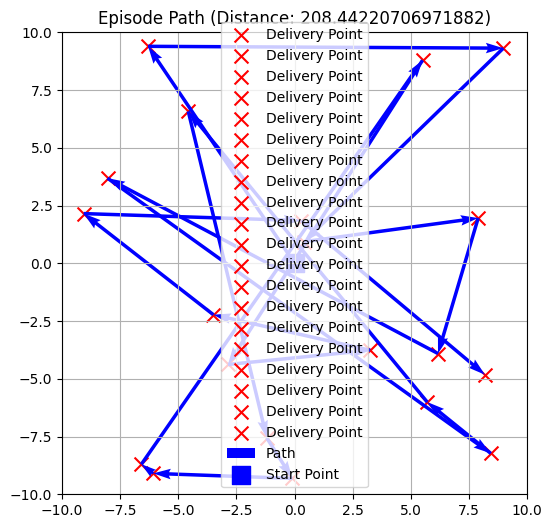

Episode 2, Total Reward: -22.489925746093398, Total Distance: 222.4899257460934, Steps: 20
Episode 3, Total Reward: -25.936933642138342, Total Distance: 225.93693364213837, Steps: 20
Episode 4, Total Reward: -21.79305707528478, Total Distance: 221.79305707528476, Steps: 20
Episode 5, Total Reward: -29.29818756976612, Total Distance: 229.29818756976616, Steps: 20
Episode 6, Total Reward: -50.13116979124978, Total Distance: 250.13116979124976, Steps: 20
Episode 7, Total Reward: -30.74828403612412, Total Distance: 230.74828403612412, Steps: 20
Episode 8, Total Reward: -28.34346222614522, Total Distance: 228.34346222614522, Steps: 20
Episode 9, Total Reward: -9.276591119005426, Total Distance: 209.27659111900536, Steps: 20
Episode 10, Total Reward: -9.413872642885138, Total Distance: 209.41387264288517, Steps: 20
Episode 11, Total Reward: -10.642829233110739, Total Distance: 210.64282923311072, Steps: 20
Episode 12, Total Reward: 5.382527797709551, Total Distance: 194.61747220229043, Steps

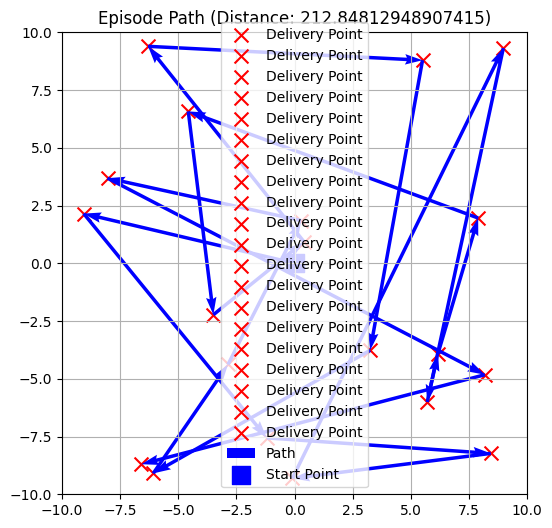

Episode 402, Total Reward: -12.613054355573993, Total Distance: 212.61305435557398, Steps: 20
Episode 403, Total Reward: -10.94036917232565, Total Distance: 210.94036917232566, Steps: 20
Episode 404, Total Reward: -15.405221075400378, Total Distance: 215.4052210754004, Steps: 20
Episode 405, Total Reward: -3.5843493040344576, Total Distance: 203.5843493040345, Steps: 20
Episode 406, Total Reward: -10.489343690316213, Total Distance: 210.4893436903162, Steps: 20
Episode 407, Total Reward: -14.360851135270972, Total Distance: 214.360851135271, Steps: 20
Episode 408, Total Reward: -0.47135754376599515, Total Distance: 200.47135754376603, Steps: 20
Episode 409, Total Reward: 6.016678228744305, Total Distance: 193.98332177125567, Steps: 20
Episode 410, Total Reward: -23.012995735188582, Total Distance: 223.01299573518858, Steps: 20
Episode 411, Total Reward: -15.747629143567298, Total Distance: 215.74762914356734, Steps: 20
Episode 412, Total Reward: -7.96041534111167, Total Distance: 207.9

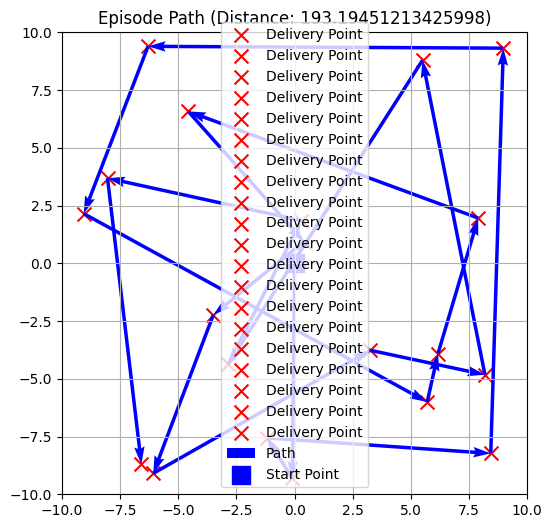

Episode 802, Total Reward: -29.031610216186635, Total Distance: 229.03161021618664, Steps: 20
Episode 803, Total Reward: -25.28629483071817, Total Distance: 225.2862948307182, Steps: 20
Episode 804, Total Reward: -28.004487199024037, Total Distance: 228.00448719902406, Steps: 20
Episode 805, Total Reward: -29.88517387665758, Total Distance: 229.8851738766576, Steps: 20
Episode 806, Total Reward: -30.713042880944464, Total Distance: 230.7130428809445, Steps: 20
Episode 807, Total Reward: -8.198629332241275, Total Distance: 208.1986293322413, Steps: 20
Episode 808, Total Reward: -24.219720682887683, Total Distance: 224.21972068288773, Steps: 20
Episode 809, Total Reward: -0.4707501185982501, Total Distance: 200.47075011859826, Steps: 20
Episode 810, Total Reward: -28.514558279671384, Total Distance: 228.5145582796714, Steps: 20
Episode 811, Total Reward: -29.88517387665758, Total Distance: 229.8851738766576, Steps: 20
Episode 812, Total Reward: -24.608805751734803, Total Distance: 224.60

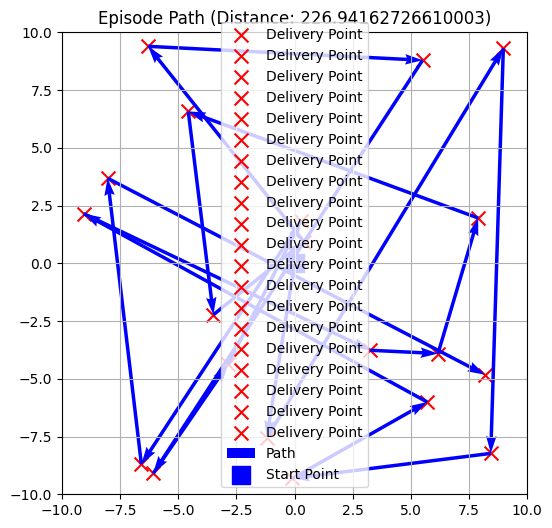

Episode 1202, Total Reward: -36.835759367046066, Total Distance: 236.83575936704608, Steps: 20
Episode 1203, Total Reward: -25.793535677029237, Total Distance: 225.79353567702927, Steps: 20
Episode 1204, Total Reward: -9.90078288246968, Total Distance: 209.90078288246968, Steps: 20
Episode 1205, Total Reward: -31.833139189234284, Total Distance: 231.8331391892343, Steps: 20
Episode 1206, Total Reward: -34.22440642396182, Total Distance: 234.22440642396185, Steps: 20
Episode 1207, Total Reward: -39.954624367333324, Total Distance: 239.95462436733328, Steps: 20
Episode 1208, Total Reward: -55.39772620514509, Total Distance: 255.3977262051451, Steps: 20
Episode 1209, Total Reward: -40.587032774781434, Total Distance: 240.58703277478145, Steps: 20
Episode 1210, Total Reward: -21.83380677871775, Total Distance: 221.83380677871776, Steps: 20
Episode 1211, Total Reward: -11.055344220442105, Total Distance: 211.0553442204421, Steps: 20
Episode 1212, Total Reward: -42.69464622292517, Total Dist

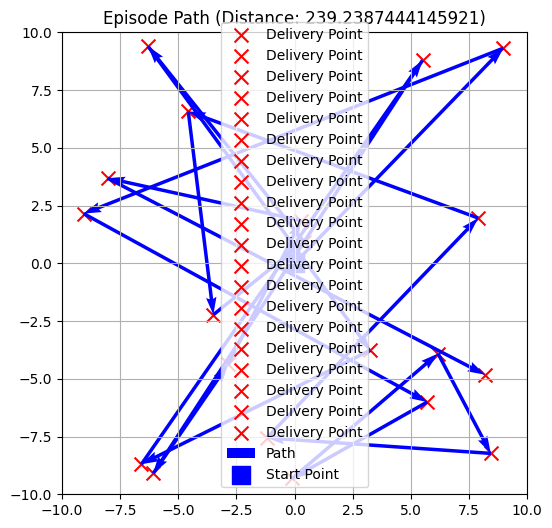

Episode 1602, Total Reward: -35.0007862980807, Total Distance: 235.0007862980807, Steps: 20
Episode 1603, Total Reward: -40.1231204008114, Total Distance: 240.12312040081144, Steps: 20
Episode 1604, Total Reward: -58.532657966263244, Total Distance: 258.5326579662632, Steps: 20
Episode 1605, Total Reward: -17.986471936184394, Total Distance: 217.98647193618442, Steps: 20
Episode 1606, Total Reward: -46.682636965979114, Total Distance: 246.68263696597907, Steps: 20
Episode 1607, Total Reward: -30.921447907299477, Total Distance: 230.9214479072995, Steps: 20
Episode 1608, Total Reward: -24.222348175064923, Total Distance: 224.22234817506495, Steps: 20
Episode 1609, Total Reward: -39.81857866529461, Total Distance: 239.8185786652946, Steps: 20
Episode 1610, Total Reward: -42.175828468158684, Total Distance: 242.1758284681587, Steps: 20
Episode 1611, Total Reward: -24.396642556470134, Total Distance: 224.39664255647014, Steps: 20
Episode 1612, Total Reward: -20.474892671029245, Total Dista

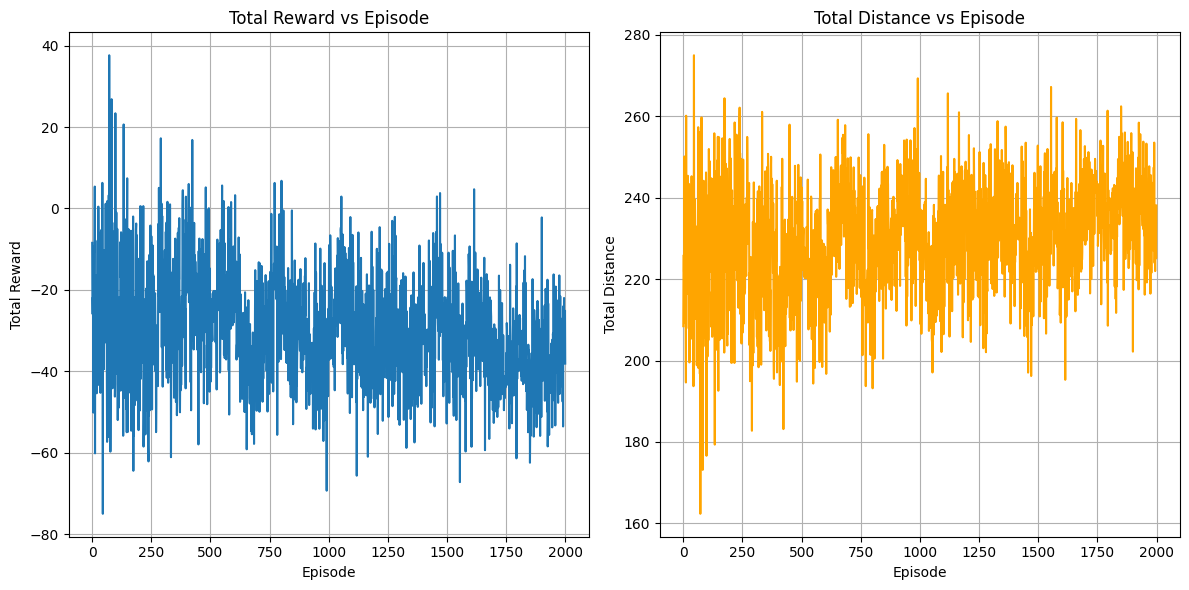

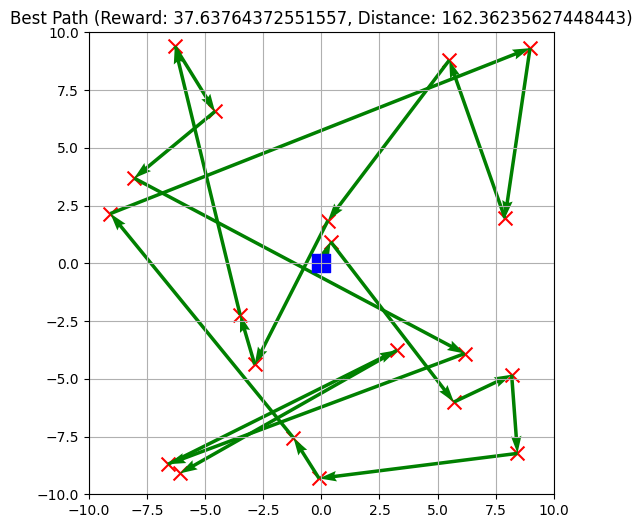

In [7]:
# Parameters
num_delivery_points = 20  # Set the number of delivery points
area_size = 10  # Continuous 2D area (e.g., 10x10)

# Initialize environment and agent
env = VRPEnvDirect(num_delivery_points, area_size)
state_dim = 2 + num_delivery_points  # x, y position + visited status for each delivery point
action_dim = num_delivery_points  # Action space: select one of the delivery points
agent = DQNAgent(state_dim, action_dim)

# Train the agent
train_vrp(env, agent, num_episodes=2000)